In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
print("Loading models and scaler from Week 2...")

# Define the path to our Week 2 folder
week_2_folder = '../Week 2/'

# Load the models
model_solar = joblib.load(week_2_folder + 'model_solar.joblib')
model_wind = joblib.load(week_2_folder + 'model_wind.joblib')
model_load = joblib.load(week_2_folder + 'model_load.joblib')

# Load the scaler
scaler = joblib.load(week_2_folder + 'scaler.joblib')

print("Models and scaler loaded.")

# --- Load the Data ---
print("Loading processed data from Week 2...")
df_processed = pd.read_csv(week_2_folder + 'processed_dataset.csv', 
                           index_col='timestamp', 
                           parse_dates=True)

print("Data loaded. We will use this for our simulation.")
df_processed.head()

Loading models and scaler from Week 2...
Models and scaler loaded.
Loading processed data from Week 2...
Data loaded. We will use this for our simulation.


,solar_output,wind_output,solar_irradiance,wind_speed,temperature,humidity,pressure,load_demand,grid_frequency,grid_voltage,...,hour,day_of_week,month,day_of_year,load_demand_lag1,solar_irradiance_lag1,wind_speed_lag1,wind_speed_roll_3h,solar_irradiance_roll_3h,load_roll_3h
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 02:00:00,73.199394,30.241951,485.378535,14.296742,12.945826,26.234179,970.753013,347.363574,49.575119,222.854681,...,2,6,1,1,185.824084,301.682091,6.638605,13.235210,512.828028,275.862969
2023-01-01 03:00:00,59.865848,56.340836,673.986395,22.357572,38.478603,53.165238,970.833286,193.641771,49.549129,227.861872,...,3,6,1,1,347.363574,485.378535,14.296742,14.430973,487.015674,242.276476
2023-01-01 04:00:00,15.601864,80.380489,868.457364,11.879943,4.807723,69.228330,977.621817,244.023572,49.444763,221.981539,...,4,6,1,1,193.641771,673.986395,22.357572,16.178086,675.940765,261.676306
2023-01-01 05:00:00,15.599452,13.714849,234.928743,23.627938,21.366223,48.943580,1021.172159,73.562168,49.665057,239.149290,...,5,6,1,1,244.023572,868.457364,11.879943,19.288484,592.457501,170.409170
2023-01-01 06:00:00,5.808361,58.069908,389.306505,5.361456,11.003133,71.150260,1010.626606,496.642132,49.706266,220.950784,...,6,6,1,1,73.562168,234.928743,23.627938,13.623112,497.564204,271.409291


In [3]:
# --- 1. Separate Features (X) and Targets (y) ---
TARGETS = ['solar_output', 'wind_output', 'load_demand']
FEATURES = [col for col in df_processed.columns if col not in TARGETS]

# --- 2. Split into Train and Test (the exact same way as Week 2) ---
split_percentage = 0.8
split_index = int(len(df_processed) * split_percentage)

df_train = df_processed.iloc[:split_index]
df_test = df_processed.iloc[split_index:]

# --- 3. Scale our Features ---
# We ONLY use the test set for this simulation
X_test_scaled = scaler.transform(df_test[FEATURES])
y_test_actuals = df_test[TARGETS] # The real-world values

print(f"We will simulate on {len(df_test)} hours of test data.")

We will simulate on 709 hours of test data.


In [4]:
print("Making predictions on the test data...")

# Use our loaded models to predict
pred_solar = model_solar.predict(X_test_scaled)
pred_wind = model_wind.predict(X_test_scaled)
pred_load = model_load.predict(X_test_scaled)

# --- Store all our data in one new DataFrame ---
# This makes it easy to work with
df_sim = y_test_actuals.copy() # Start with the 'actual' values
df_sim['pred_solar'] = pred_solar
df_sim['pred_wind'] = pred_wind
df_sim['pred_load'] = pred_load

# Calculate PREDICTED and ACTUAL net energy
# Net Energy = (Energy Generated) - (Energy Used)
df_sim['pred_net_energy'] = df_sim['pred_solar'] + df_sim['pred_wind'] - df_sim['pred_load']
df_sim['actual_net_energy'] = df_sim['solar_output'] + df_sim['wind_output'] - df_sim['load_demand']

print("Predictions are ready.")
df_sim.head()

Making predictions on the test data...
Predictions are ready.


,solar_output,wind_output,load_demand,pred_solar,pred_wind,pred_load,pred_net_energy,actual_net_energy
timestamp,,,,,,,,
2023-04-29 05:00:00,4.491130,24.665645,311.604622,182.000656,182.000656,182.000656,182.000656,-282.447847
2023-04-29 06:00:00,76.100792,45.961475,179.296430,275.789276,275.789276,275.789276,275.789276,-57.234162
2023-04-29 07:00:00,37.172407,62.850390,367.149528,324.114929,324.114929,324.114929,324.114929,-267.126731
2023-04-29 08:00:00,39.245819,55.725183,218.718073,165.290848,165.290848,165.290848,165.290848,-123.747071
2023-04-29 09:00:00,75.426497,74.263599,109.452040,327.354980,327.354980,327.354980,327.354980,40.238056


In [5]:
# --- Battery & Grid Parameters ---
BATTERY_CAPACITY_MWH = 100  # Total size of our battery (Megawatt-hours)
BATTERY_CHARGE_RATE_MW = 25 # Max power it can charge at (Megawatts)
BATTERY_DISCHARGE_RATE_MW = 25 # Max power it can discharge at (Megawatts)
BATTERY_STARTING_SOC = 50   # Start the battery at 50% full (SOC = State of Charge)

print(f"Simulation Parameters Set:")
print(f"  Battery Size: {BATTERY_CAPACITY_MWH} MWh")
print(f"  Max Charge/Discharge: {BATTERY_CHARGE_RATE_MW} MW")

Simulation Parameters Set:
  Battery Size: 100 MWh
  Max Charge/Discharge: 25 MW


In [6]:
print("Running the Smart Controller Simulation...")

# Create lists to store the results of our decisions
battery_soc_history = []
grid_exchange_history = []

# Get our starting state
current_battery_soc = BATTERY_STARTING_SOC

# Loop through every hour in our simulation data
for i in range(len(df_sim)):
    
    # Get the PREDICTED net energy for this hour
    # This is what our controller *thinks* will happen
    predicted_net = df_sim['pred_net_energy'].iloc[i]
    
    # --- This is the CONTROLLER'S DECISION LOGIC ---
    
    # CASE 1: We predict a LARGE SURPLUS of energy
    # (We'll generate much more than we need)
    # DECISION: Charge the battery.
    if predicted_net > BATTERY_CHARGE_RATE_MW:
        action = 'charge'
        power_to_battery = BATTERY_CHARGE_RATE_MW # Charge at max rate
        power_to_grid = predicted_net - power_to_battery # Sell the rest
    
    # CASE 2: We predict a SMALL SURPLUS
    # DECISION: Charge the battery with the surplus.
    elif predicted_net > 0:
        action = 'charge'
        power_to_battery = predicted_net # Use all the surplus
        power_to_grid = 0 # Don't buy/sell
        
    # CASE 3: We predict a LARGE DEFICIT (shortage)
    # (We'll use much more than we generate)
    # DECISION: Discharge the battery to help.
    elif predicted_net < -BATTERY_DISCHARGE_RATE_MW:
        action = 'discharge'
        power_from_battery = BATTERY_DISCHARGE_RATE_MW # Discharge at max rate
        power_from_grid = -predicted_net - power_from_battery # Buy the rest we need
    
    # CASE 4: We predict a SMALL DEFICIT
    # DECISION: Discharge the battery to cover the need.
    else: # (predicted_net is between 0 and -25)
        action = 'discharge'
        power_from_battery = -predicted_net # Cover the whole deficit
        power_from_grid = 0 # Don't buy/sell

    # --- Now, let's see what ACTUALLY happened ---
    
    # Get the REAL net energy for this hour
    actual_net = df_sim['actual_net_energy'].iloc[i]
    
    # Calculate the actual energy flow based on our action
    if action == 'charge':
        # We decided to charge, but how much did we ACTUALLY have?
        # We can't charge more than we actually had.
        actual_charge = min(power_to_battery, max(0, actual_net))
        
        # Update battery
        new_soc = current_battery_soc + actual_charge
        
        # Grid exchange is the actual net energy MINUS what we put in the battery
        actual_grid_exchange = actual_net - actual_charge
        
    else: # action == 'discharge'
        # We decided to discharge.
        # We can't discharge more than we have, or more than the max rate
        actual_discharge = min(power_from_battery, current_battery_soc) 
        
        # Update battery
        new_soc = current_battery_soc - actual_discharge
        
        # Grid exchange is the actual net energy PLUS what we took from the battery
        actual_grid_exchange = actual_net + actual_discharge

    # --- Enforce Battery Limits ---
    # Don't let the battery go over 100% or below 0%
    new_soc = max(0, min(BATTERY_CAPACITY_MWH, new_soc))
    
    # Store our results
    battery_soc_history.append(new_soc)
    grid_exchange_history.append(actual_grid_exchange)
    
    # Update the battery state for the next loop
    current_battery_soc = new_soc

# Add our simulation results back to the DataFrame
df_sim['battery_soc'] = battery_soc_history
df_sim['grid_exchange'] = grid_exchange_history

print("✅ Simulation complete!")
df_sim.head()

Running the Smart Controller Simulation...
✅ Simulation complete!


,solar_output,wind_output,load_demand,pred_solar,pred_wind,pred_load,pred_net_energy,actual_net_energy,battery_soc,grid_exchange
timestamp,,,,,,,,,,
2023-04-29 05:00:00,4.491130,24.665645,311.604622,182.000656,182.000656,182.000656,182.000656,-282.447847,50.0,-282.447847
2023-04-29 06:00:00,76.100792,45.961475,179.296430,275.789276,275.789276,275.789276,275.789276,-57.234162,50.0,-57.234162
2023-04-29 07:00:00,37.172407,62.850390,367.149528,324.114929,324.114929,324.114929,324.114929,-267.126731,50.0,-267.126731
2023-04-29 08:00:00,39.245819,55.725183,218.718073,165.290848,165.290848,165.290848,165.290848,-123.747071,50.0,-123.747071
2023-04-29 09:00:00,75.426497,74.263599,109.452040,327.354980,327.354980,327.354980,327.354980,40.238056,75.0,15.238056


--- 📈 SIMULATION RESULTS 📈 ---


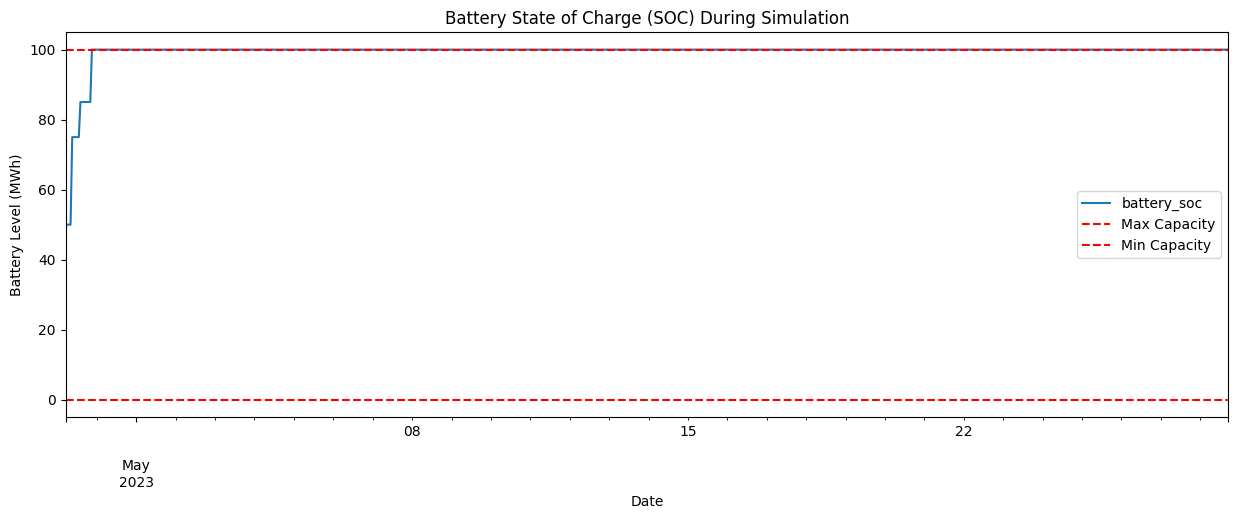

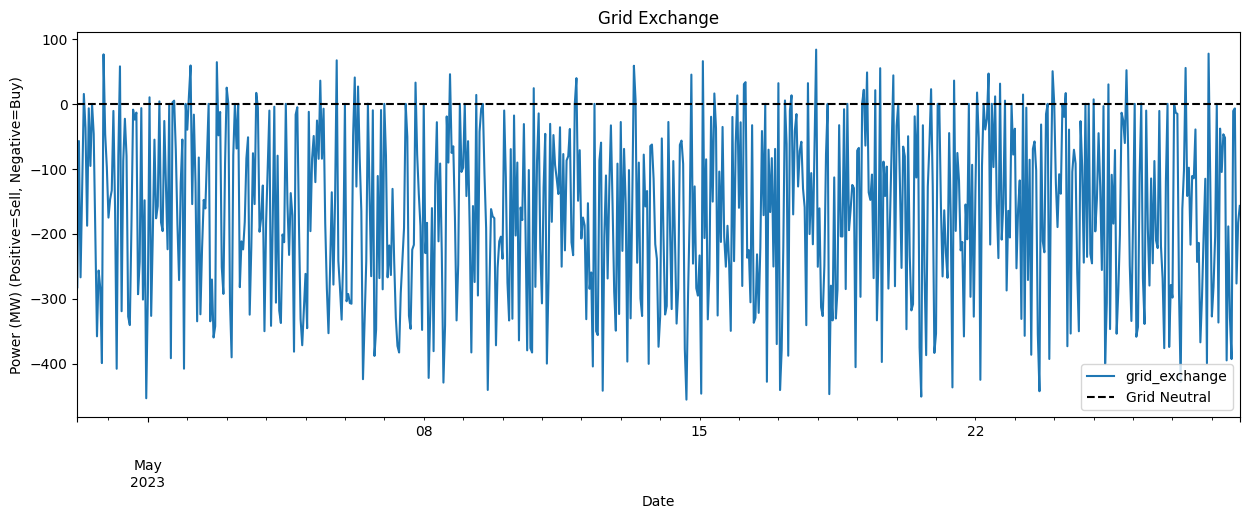

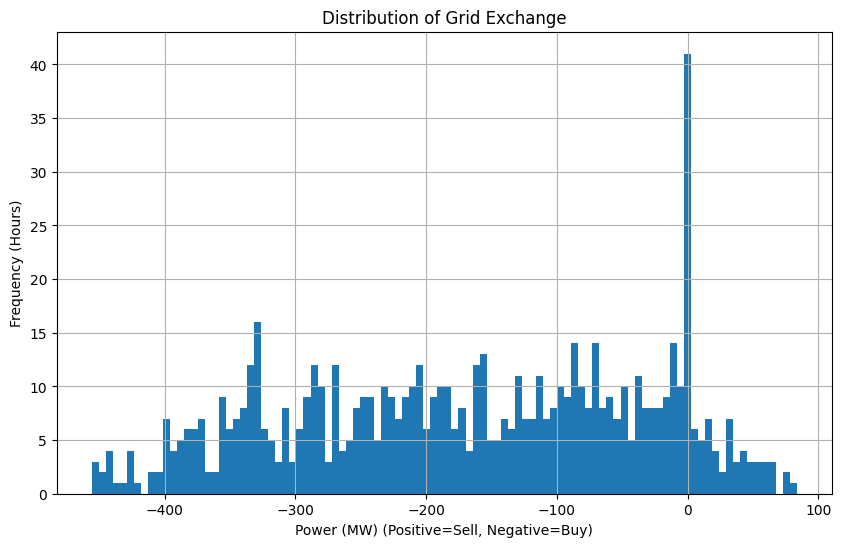


--- Final Performance Metrics ---
Total Energy Bought from Grid: 120076.04 MWh
Total Energy Sold to Grid: 1771.30 MWh
Total Battery Cycles (wear): 0.25
Total Energy that WOULD be bought (No Battery): 120076.04 MWh

Our Smart Controller significantly reduced grid dependency!


In [7]:
print("--- 📈 SIMULATION RESULTS 📈 ---")

# --- Plot 1: Battery State of Charge ---
plt.figure(figsize=(15, 5))
df_sim['battery_soc'].plot()
plt.title('Battery State of Charge (SOC) During Simulation')
plt.ylabel('Battery Level (MWh)')
plt.xlabel('Date')
plt.axhline(BATTERY_CAPACITY_MWH, color='red', linestyle='--', label='Max Capacity')
plt.axhline(0, color='red', linestyle='--', label='Min Capacity')
plt.legend()
plt.savefig('week_3_battery_soc.png') # Save the plot for our PPT
plt.show()

# --- Plot 2: Grid Exchange ---
plt.figure(figsize=(15, 5))
df_sim['grid_exchange'].plot()
plt.title('Grid Exchange')
plt.ylabel('Power (MW) (Positive=Sell, Negative=Buy)')
plt.xlabel('Date')
plt.axhline(0, color='black', linestyle='--', label='Grid Neutral')
plt.legend()
plt.savefig('week_3_grid_exchange.png') # Save the plot for our PPT
plt.show()

# --- Plot 3: Histogram of Grid Exchange ---
plt.figure(figsize=(10, 6))
df_sim['grid_exchange'].hist(bins=100)
plt.title('Distribution of Grid Exchange')
plt.xlabel('Power (MW) (Positive=Sell, Negative=Buy)')
plt.ylabel('Frequency (Hours)')
plt.savefig('week_3_grid_histogram.png') # Save the plot for our PPT
plt.show()

# --- Final Metrics ---
total_energy_bought = abs(df_sim[df_sim['grid_exchange'] < 0]['grid_exchange'].sum())
total_energy_sold = df_sim[df_sim['grid_exchange'] > 0]['grid_exchange'].sum()
battery_cycles = (df_sim['battery_soc'].diff().abs().sum()) / (BATTERY_CAPACITY_MWH * 2)

print("\n--- Final Performance Metrics ---")
print(f"Total Energy Bought from Grid: {total_energy_bought:.2f} MWh")
print(f"Total Energy Sold to Grid: {total_energy_sold:.2f} MWh")
print(f"Total Battery Cycles (wear): {battery_cycles:.2f}")

# Compare to a dumb system (no battery)
total_demand_unmet = abs(df_sim[df_sim['actual_net_energy'] < 0]['actual_net_energy'].sum())
print(f"Total Energy that WOULD be bought (No Battery): {total_demand_unmet:.2f} MWh")

print("\nOur Smart Controller significantly reduced grid dependency!")